## Import Library

In [149]:
import os, errno
import argparse
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from scipy.stats import kurtosis
from scipy.stats.mstats import moment
from scipy import stats
from scipy.stats import ttest_ind, f_oneway

sys.path.append(os.path.join(os.path.curdir, '../../', 'util'))
from load_data_basic import *

# date_time format
date_time_format = '%Y-%m-%dT%H:%M:%S.%f'
date_only_date_time_format = '%Y-%m-%d'

# sleep after work duration thereshold
sleep_after_work_duration_threshold = 12
sleep_after_sleep_duration_threshold = 2

# data folder
main_data_directory = '../../../data/'
recording_timeline_directory = '../../output/recording_timeline'
sleep_timeline_directory = '../../output/sleep_timeline'
individual_timeline_directory = '../../output/individual_timeline'



## Read Basic Information

In [150]:
# Read sleep data for all participant
sleep_data = pd.read_csv(os.path.join('../../output', 'sleep_survey_full.csv'))

# Read participant information
participant_info = getParticipantInfo(main_data_directory)
# participant_info = participant_info.set_index('MitreID')

# Read MGT
MGT = read_MGT(main_data_directory)

# Read Pre-Study info
PreStudyInfo = read_pre_study_info(main_data_directory)

# Read IGTB info
IGTB = read_IGTB(main_data_directory)

# Demographic
Demographic = read_Demographic(main_data_directory)

# Day shift data
day_data = sleep_data.loc[sleep_data['shift_type'] == 1]
day_workday_data = day_data.loc[(day_data['is_sleep_before_work'] == 1) & (day_data['is_sleep_after_work'] == 1)]
day_off_day_data = day_data.loc[(day_data['is_sleep_before_work'] != 1) & (day_data['is_sleep_after_work'] != 1)]
day_transition_day_data = day_data.loc[(day_data['is_sleep_transition_before_work'] == 1) | (day_data['is_sleep_transition_after_work'] == 1)]

# Night shift data
night_data = sleep_data.loc[sleep_data['shift_type'] == 2]
night_workday_data = night_data.loc[(night_data['is_sleep_before_work'] == 1) & (night_data['is_sleep_after_work'] == 1)]
night_off_day_data = night_data.loc[(night_data['is_sleep_before_work'] != 1) & (night_data['is_sleep_after_work'] != 1)]
night_transition_day_data = night_data.loc[(night_data['is_sleep_transition_before_work'] == 1) | (night_data['is_sleep_transition_after_work'] == 1)]

# Data array
data_array = [day_data, night_data, 
              day_workday_data, day_off_day_data, 
              night_workday_data, night_off_day_data]

data_type = ['day-shift all', 'night-shift all',
             'day-shift workday', 'day-shift off day', 
             'night-shift workday', 'night-shift off day']

colunm_type = ['duration_in_seconds', 'SleepEfficiency',
               'SleepMinutesStageDeep', 'SleepMinutesStageLight', 'SleepMinutesStageRem',
               'sleep_heart_rate_mean', 'sleep_heart_rate_std',
               'sleep_heart_rate_percentile_10', 'sleep_heart_rate_percentile_90']

UserInfo = pd.merge(IGTB, PreStudyInfo, left_on='uid', right_on='uid', how='outer')
UserInfo = pd.merge(UserInfo, participant_info, left_on='uid', right_on='MitreID', how='outer')
UserInfo = pd.merge(UserInfo, Demographic, left_on='uid', right_on='uid', how='outer')
UserInfo = UserInfo.set_index('uid')
UserInfo = UserInfo.loc[UserInfo['Wave'] != 3]


## Raw IGTB - PSQI

In [151]:
raw_IGTB_col = ['psqi_inst', 'psqi1', 'psqi1ampm', 'psqi2', 'psqi3', 'psqi3ampm', 'psqi4',
                'psqi5a', 'psqi5b', 'psqi5c', 'psqi5d', 'psqi5e', 'psqi5f', 'psqi5g', 'psqi5h',
                'psqi5i', 'psqi5ja', 'psqi5jb', 'psqi6', 'psqi7', 'psqi8', 'psqi9', 'psqi_complete', 
                'gats1', 'gats2', 'gats3Week_1', 'gats3Week_2', 'gats3Week_3', 
                'gats3Week_4', 'gats3Week_5', 'gats3Week_6', 'gats3Week_7', 
                'audit1', 'audit2', 'audit3', 'audit4', 'audit5', 
                'audit6', 'audit7', 'audit8', 'audit9', 'audit10', 'Name']

IGTB_RAW = read_IGTB_Raw(main_data_directory)[raw_IGTB_col]
IGTB_RAW = IGTB_RAW.loc[IGTB_RAW['Name'].isin(UserInfo.index.values)]
IGTB_RAW_Score = pd.DataFrame()

for user_id in UserInfo.index.values:
    IGTB_RAW_participant = IGTB_RAW.loc[IGTB_RAW['Name'] == user_id]
    IGTB_participant = UserInfo.loc[user_id]
    
    # PSQI
    # Contains 7 scores, the lower the score, the better the performance
    frame = pd.DataFrame(index=[user_id])
    frame['Shift'] = 1 if IGTB_participant['Shift'] == 'Day shift' else 2
    frame['sleep_score'] = IGTB_participant['psqi_igtb']
    
    # 1st score
    frame['subjective_sleep_quality_psqi'] = IGTB_RAW_participant['psqi6'].values[0]
    
    # 2nd score
    if IGTB_RAW_participant['psqi2'].values[0] <= 15:
        response = 0
    elif 15 < IGTB_RAW_participant['psqi2'].values[0] <= 30:
        response = 1
    elif 30 < IGTB_RAW_participant['psqi2'].values[0] <= 60:
        response = 2
    elif IGTB_RAW_participant['psqi2'].values[0] > 60:
        response = 3
     
    frame['sleep_latency_psqi'] = int((response + IGTB_RAW_participant['psqi5a'].values[0] + 1) / 2)
    
    # 3rd score
    if IGTB_RAW_participant['psqi4'].values[0] >= 7:
        response = 0
    elif 6 <= IGTB_RAW_participant['psqi4'].values[0] < 7:
        response = 1
    elif 5 <= IGTB_RAW_participant['psqi4'].values[0] < 6:
        response = 2
    elif IGTB_RAW_participant['psqi4'].values[0] < 5:
        response = 3
    frame['sleep_duration_psqi'] = response
    
    # 4th score
    in_bed_time = int(IGTB_RAW_participant['psqi1'].values[0] / 100)
    in_bed_time = in_bed_time + int(IGTB_RAW_participant['psqi1'].values[0] % 100) / 60
    
    get_up_time = int(IGTB_RAW_participant['psqi3'].values[0] / 100)
    get_up_time = get_up_time + int(IGTB_RAW_participant['psqi3'].values[0] % 100) / 60
    
    if in_bed_time >= 12:
        in_bed_time = in_bed_time - 12
    
    if get_up_time >= 12:
        get_up_time = get_up_time - 12
    
    if IGTB_RAW_participant['psqi1ampm'].values[0] == 1200 and IGTB_RAW_participant['psqi3ampm'].values[0] == 0:
        time_in_bed = 12 - in_bed_time + get_up_time
    elif IGTB_RAW_participant['psqi1ampm'].values[0] == 0 and IGTB_RAW_participant['psqi3ampm'].values[0] == 1200:
        time_in_bed = 12 - in_bed_time + get_up_time
    else:
        time_in_bed = get_up_time - in_bed_time
    
    efficiency = 100 * IGTB_RAW_participant['psqi4'].values[0] / time_in_bed
    
    if efficiency < 0:
        efficiency = 100
    
    if efficiency >= 85:
        response = 0
    elif 75 <= efficiency < 85:
        response = 1
    elif 65 <= efficiency < 75:
        response = 2
    elif efficiency < 65:
        response = 3
    frame['sleep_efficiency_psqi'] = response
    
    # 5th score
    response = IGTB_RAW_participant['psqi5b'].values[0] + IGTB_RAW_participant['psqi5c'].values[0] + IGTB_RAW_participant['psqi5d'].values[0] + IGTB_RAW_participant['psqi5e'].values[0] + IGTB_RAW_participant['psqi5f'].fillna(0).values[0] + IGTB_RAW_participant['psqi5g'].values[0] + IGTB_RAW_participant['psqi5h'].values[0] + IGTB_RAW_participant['psqi5i'].values[0] 
    response = response + IGTB_RAW_participant['psqi5jb'].fillna(0)
    frame['sleep_distrubance_psqi'] = int((response + 8) / 9)
    
    # 6th score
    frame['sleep_medication_psqi'] = IGTB_RAW_participant['psqi7'].values[0]
    
    # 7th score
    response = IGTB_RAW_participant['psqi8'].values[0] + IGTB_RAW_participant['psqi9'].values[0]
    frame['daytime_dysfunction_psqi'] = int((response + 1) / 2)
    
    IGTB_RAW_Score = IGTB_RAW_Score.append(frame)


## IGTB (Sleep) - Day, Night shift

sleep_score

Number of valid participant: day: 110; night: 57

Total: mean = 7.31, std = 2.32, range is 4.000 - 17.000
Day shift: mean = 6.86, std = 1.85, range is 4.000 - 11.000
Night shift: mean = 8.18, std = 2.84, range is 4.000 - 17.000 

Statistics = -3.568, p = 0.000


subjective_sleep_quality_psqi

Number of valid participant: day: 110; night: 57

Total: mean = 0.46, std = 0.93, range is 0.000 - 3.000
Day shift: mean = 0.39, std = 0.87, range is 0.000 - 3.000
Night shift: mean = 0.60, std = 1.02, range is 0.000 - 3.000 

Statistics = -1.349, p = 0.179


sleep_latency_psqi

Number of valid participant: day: 110; night: 57

Total: mean = 1.29, std = 0.97, range is 0.000 - 3.000
Day shift: mean = 1.25, std = 0.93, range is 0.000 - 3.000
Night shift: mean = 1.39, std = 1.04, range is 0.000 - 3.000 

Statistics = -0.886, p = 0.377


sleep_duration_psqi

Number of valid participant: day: 110; night: 57

Total: mean = 0.90, std = 0.90, range is 0.000 - 3.000
Day shift: mean = 0.85, std

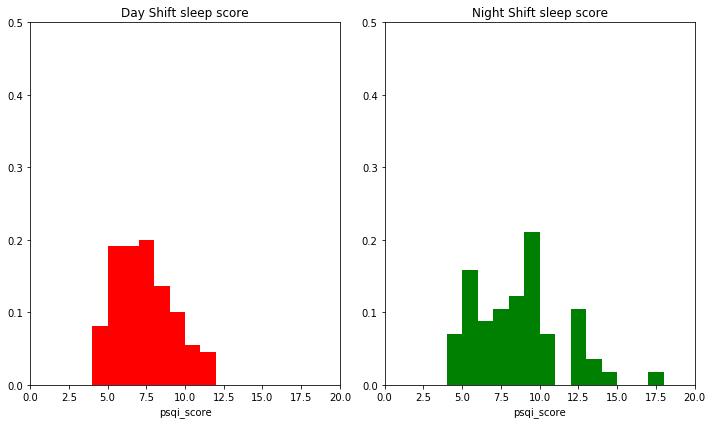

In [152]:
sleep_col = ['sleep_score',
             'subjective_sleep_quality_psqi', 'sleep_latency_psqi', 'sleep_duration_psqi',
             'sleep_efficiency_psqi', 'sleep_distrubance_psqi', 'sleep_medication_psqi', 'daytime_dysfunction_psqi']

# shift_pre-study
day_sleep_stats   = IGTB_RAW_Score.loc[(IGTB_RAW_Score['Shift'] == 1)].dropna(subset=['sleep_score'])
night_sleep_stats = IGTB_RAW_Score.loc[(IGTB_RAW_Score['Shift'] == 2)].dropna(subset=['sleep_score'])

overall_data = [day_sleep_stats, night_sleep_stats]
data_type = ['day-shift', 'night-shift']

for col in sleep_col:

    print(col + '\n')
    print('Number of valid participant: day: %i; night: %i\n' % (len(day_sleep_stats), len(night_sleep_stats)))
    
    print('Total: mean = %.2f, std = %.2f, range is %.3f - %.3f' % (np.mean(IGTB_RAW_Score[col]), np.std(IGTB_RAW_Score[col]), np.min(IGTB_RAW_Score[col]), np.max(IGTB_RAW_Score[col])))
    print('Day shift: mean = %.2f, std = %.2f, range is %.3f - %.3f' % (np.mean(day_sleep_stats[col]), np.std(day_sleep_stats[col]), np.min(day_sleep_stats[col]), np.max(day_sleep_stats[col])))
    print('Night shift: mean = %.2f, std = %.2f, range is %.3f - %.3f \n' % (np.mean(night_sleep_stats[col]), np.std(night_sleep_stats[col]), np.min(night_sleep_stats[col]), np.max(night_sleep_stats[col])))
    
    stat, p = ttest_ind(day_sleep_stats[col].dropna(), night_sleep_stats[col].dropna())
    # print('Type: ' + col)
    print('Statistics = %.3f, p = %.3f' % (stat, p))
    print('\n')

# Plot histgram
# color
color = ['r', 'g']

# Title
title = ['Day Shift sleep score', 'Night Shift sleep score']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

num_of_bins = range(0, 20, 1)

for i in range(len(axes.flatten())):
    axes[i].set_xlim([0, 20])
    axes[i].set_ylim([0, 0.5])
    axes[i].set_xlabel('psqi_score', fontsize=10)
    
    axes[i].hist(list(overall_data[i]['sleep_score'].dropna()), normed=True, bins=num_of_bins, color=color[i])
    axes[i].set_title(title[i])

fig.tight_layout()
plt.show()



## Convert to Latex

In [180]:
latex_col = ['Total PSQI score', 'Subjective sleep quality',
             'Sleep latency', 'Sleep duration', 'Sleep efficiency',
             'Sleep disturbance', 'Sleep medication', 'Daytime dysfunction']

start = '\\begin{tabular}{p{3cm}p{2cm}p{2cm}p{2cm}p{2cm}}' 

latex_output = start + '\n\t\multicolumn{1}{p{3cm}}{} & '
latex_output = latex_output + '\n\t\multicolumn{1}{p{2.5cm}}{} & '
latex_output = latex_output + '\n\t\multicolumn{1}{p{2.5cm}}{} & '
latex_output = latex_output + '\n\t\multicolumn{1}{p{2.5cm}}{} & '
latex_output = latex_output + '\n\t\multicolumn{1}{p{2.5cm}}{}\\\\'

# Header
latex_output = latex_output + '\n\n\t\hline'
latex_output = latex_output + '\n\t\\rule{0pt}{2ex}'
latex_output = latex_output + '\n\t\multirow{2}{*}{{Items}} & '
latex_output = latex_output + '\n\t\multicolumn{1}{c}{{Total (n = $%d$)}} & ' % (len(day_sleep_stats) + len(night_sleep_stats))
latex_output = latex_output + '\n\t\multicolumn{1}{c}{{Day shift (n = $%d$)}} & ' % (len(day_sleep_stats))
latex_output = latex_output + '\n\t\multicolumn{1}{c}{{Night shift (n = $%d$)}} & ' % (len(night_sleep_stats))
latex_output = latex_output + '\n\t\multicolumn{1}{c}{\multirow{2}{*}{{\centering P-value}}} \\\\  & '
latex_output = latex_output + '\n\t\multicolumn{1}{c}{{Mean $\pm$ SD}} & '
latex_output = latex_output + '\n\t\multicolumn{1}{c}{{Mean $\pm$ SD}} & '
latex_output = latex_output + '\n\t\multicolumn{1}{c}{{Mean $\pm$ SD}} &'
latex_output = latex_output + '\n\t\\rule{0pt}{2ex}\\\\'
latex_output = latex_output + '\n\t\hline'

# Score
for idx, col in enumerate(sleep_col):
    
    stat, p = ttest_ind(day_sleep_stats[col].dropna(), night_sleep_stats[col].dropna())
    
    latex_output = latex_output + '\n'
    
    if col is 'sleep_score':
        latex_output = latex_output + '\n\t\multicolumn{1}{l}{%s} &' % (latex_col[idx])
    else:
        latex_output = latex_output + '\n\t\multicolumn{1}{l}{\hspace{0.5cm}%s} &' % (latex_col[idx])
        
    latex_output = latex_output + '\n\t\multicolumn{1}{c}{$%.2f$ $\pm$ $%.2f$} & ' % (np.mean(IGTB_RAW_Score[col]), np.std(IGTB_RAW_Score[col]))
    latex_output = latex_output + '\n\t\multicolumn{1}{c}{$%.2f$ $\pm$ $%.2f$} & ' % (np.mean(day_sleep_stats[col]), np.std(day_sleep_stats[col]))
    latex_output = latex_output + '\n\t\multicolumn{1}{c}{$%.2f$ $\pm$ $%.2f$} & ' % (np.mean(night_sleep_stats[col]), np.std(night_sleep_stats[col]))
    
    if p < 0.05:
        latex_output = latex_output + '\n\t\multicolumn{1}{c}{$\mathbf{%.3f}$} \\rule{0pt}{3ex} \\\\' % (p)
    else:
        latex_output = latex_output + '\n\t\multicolumn{1}{c}{$%.3f$} \\rule{0pt}{3ex} \\\\' % (p)
    
latex_output = latex_output + '[1mm]\n'
latex_output = latex_output + '\n\t\hline'
latex_output = latex_output + '\n\n'
latex_output = latex_output + '\end{tabular}'

print(latex_output)



\begin{tabular}{p{3cm}p{2cm}p{2cm}p{2cm}p{2cm}}
	\multicolumn{1}{p{3cm}}{} & 
	\multicolumn{1}{p{2.5cm}}{} & 
	\multicolumn{1}{p{2.5cm}}{} & 
	\multicolumn{1}{p{2.5cm}}{} & 
	\multicolumn{1}{p{2.5cm}}{}\\

	\hline
	\rule{0pt}{2ex}
	\multirow{2}{*}{{Items}} & 
	\multicolumn{1}{c}{{Total (n = $167$)}} & 
	\multicolumn{1}{c}{{Day shift (n = $110$)}} & 
	\multicolumn{1}{c}{{Night shift (n = $57$)}} & 
	\multicolumn{1}{c}{\multirow{2}{*}{{\centering P-value}}} \\  & 
	\multicolumn{1}{c}{{Mean $\pm$ SD}} & 
	\multicolumn{1}{c}{{Mean $\pm$ SD}} & 
	\multicolumn{1}{c}{{Mean $\pm$ SD}} &
	\rule{0pt}{2ex}\\
	\hline

	\multicolumn{1}{l}{Total PSQI score} &
	\multicolumn{1}{c}{$7.31$ $\pm$ $2.32$} & 
	\multicolumn{1}{c}{$6.86$ $\pm$ $1.85$} & 
	\multicolumn{1}{c}{$8.18$ $\pm$ $2.84$} & 
	\multicolumn{1}{c}{$\mathbf{0.000}$} \rule{0pt}{3ex} \\

	\multicolumn{1}{l}{\hspace{0.5cm}Subjective sleep quality} &
	\multicolumn{1}{c}{$0.46$ $\pm$ $0.93$} & 
	\multicolumn{1}{c}{$0.39$ $\pm$ $0.87$} & 
	\mult